In [1]:
# More distance stuff
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
# Importing GemPy
import gempy as gp
# Embedding matplotlib figures in the notebooks
%matplotlib inline
# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
os.pardir = '../..'

In [3]:
# set resolution, extent and input data
geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[50,1,50], 
                        path_o = os.pardir+"/data/input_data/jan_models/model2_orientations.csv",
                        path_i = os.pardir+"/data/input_data/jan_models/model2_surface_points.csv") 

Active grids: ['regular']


In [4]:
#F4B400
#DB4437
#4285F4
geo_data.surfaces.colors.change_colors({"rock1": '#DB4437', "rock2": "#4285F4", "basement": "#F4B400"})

,surface,series,order_surfaces,isBasement,color,id
0,rock1,Default series,1,False,#DB4437,1
1,rock2,Default series,2,False,#4285F4,2
2,basement,Basement,1,True,#F4B400,3


In [5]:
#geo_data.surfaces.colors.change_colors()

In [6]:
# define series and assign surfaces
gp.map_series_to_surfaces(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')})

,surface,series,order_surfaces,isBasement,color,id
0,rock1,Strat_Series,1,False,#DB4437,1
1,rock2,Strat_Series,2,False,#4285F4,2
2,basement,Basement_Series,1,True,#F4B400,3


In [7]:
# define the interpolator
interp_data = gp.set_interpolation_data(geo_data, compile_theano=True,
                                        theano_optimizer='fast_compile')

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!


In [8]:
#calcualte the solution
sol = gp.compute_model(geo_data, compute_mesh=False)

In [9]:
sol.lith_block.shape
sol.grid.regular_grid.values[:,1].shape

(2500,)

In [10]:
sol.scalar_field_matrix.shape
sol.gradient

array([], dtype=float64)

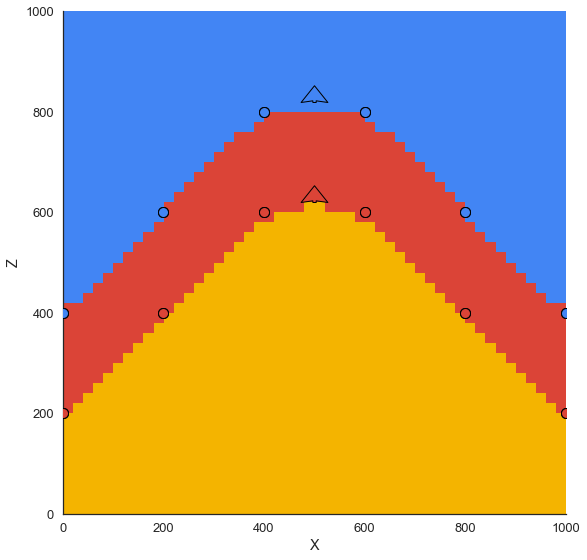

In [11]:
gp.plot.plot_section(geo_data, cell_number=0)

In [12]:
# gradient not implemented in gempy 2.0
np.unique(sol.lith_block)

array([1.        , 1.        , 1.        , 1.00036557, 1.00036557,
       1.00109184, 1.00109184, 2.        , 2.        , 2.        ,
       3.        ])

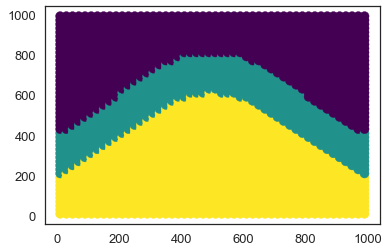

In [13]:
plt.scatter(sol.grid.regular_grid.values[:,0], sol.grid.regular_grid.values[:,2], c=sol.lith_block, cmap='viridis')

In [14]:
#sol.scalar_field_matrix[0]

In [15]:
x =  np.unique(sol.grid.regular_grid.values[:,0])
y =  np.unique(sol.grid.regular_grid.values[:,2])

In [16]:
X, Y = np.meshgrid(x, y)

zs = sol.scalar_field_matrix
Z = zs.reshape(X.shape)


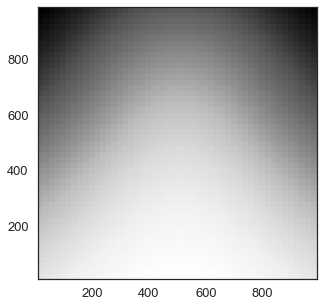

In [37]:
fig = plt.figure(figsize=(5,5))
plt.pcolor(Y, X, Z)
plt.show()

In [17]:
sol.grid.regular_grid.resolution

array([50,  1, 50])

In [57]:
gx, gy = np.gradient(Z,1,1)

In [63]:
gx.shape

(50, 50)

2d rotation

|cos θ   −sin θ| |x| = |x cos θ − y sin θ| = |x'|
|sin θ    cos θ| |y|   |x sin θ + y cos θ|   |y'|

In [67]:
def rotate_2d(x, y, angle):
    new_x = x*np.cos(angle)-y*np.sin(angle)
    new_y = x*np.sin(angle)+y*np.cos(angle)
    return new_x, new_y

In [100]:
rot_x, rot_y = rotate_2d(gx, gy, 90)

In [96]:
    | cos θ    0   sin θ| |x|   | x cos θ + z sin θ|   |x'|
    |   0      1       0| |y| = |         y        | = |y'|
    |−sin θ    0   cos θ| |z|   |−x sin θ + z cos θ|   |z'|

around the X-axis would be

    |1     0           0| |x|   |        x        |   |x'|
    |0   cos θ    −sin θ| |y| = |y cos θ − z sin θ| = |y'|
    |0   sin θ     cos θ| |z|   |y sin θ + z cos θ|   |z'|


SyntaxError: invalid syntax (<ipython-input-96-9baf9faa11ae>, line 1)

In [97]:
gx.shape

(50, 50)

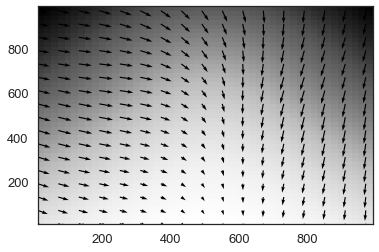

In [98]:
fig, ax = plt.subplots()

plt.pcolor(Y, X, Z)

#q = ax.quiver(Y[::3, ::3], X[::3, ::3], gx[::3, ::3], gy[::3, ::3])
q = ax.quiver(Y[::3, ::3], X[::3, ::3], rot_x[::3, ::3], rot_y[::3, ::3])

ax.quiverkey(q, X=0.3, Y=1.1, U=1,
             label='Quiver key, length = 1')

#plt.scatter(sol.grid.regular_grid.values[:,0], sol.grid.regular_grid.values[:,2], s=10, c=sol.lith_block, cmap='viridis')
plt.show()

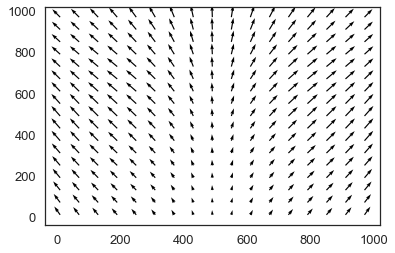

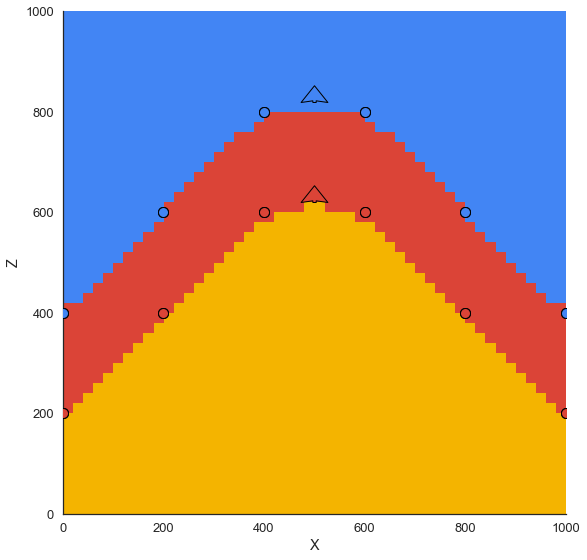

In [90]:

fig, ax = plt.subplots()
#q = ax.quiver(Y, X, gx, gy)
q = ax.quiver(Y[::3, ::3], X[::3, ::3], gx[::3, ::3], gy[::3, ::3])

#ax.quiverkey(q, X=0.3, Y=1.1, U=1, label='Quiver key, length = 1')

#plt.scatter(sol.grid.regular_grid.values[:,0], sol.grid.regular_grid.values[:,2], s=10, c=sol.lith_block, cmap='viridis')

gp.plot.plot_section(geo_data, cell_number=0)

plt.show()

../../..\gempy\plot\visualization_2d.py:854: UserWarning: linewidths is ignored by contourf
  **kwargs)


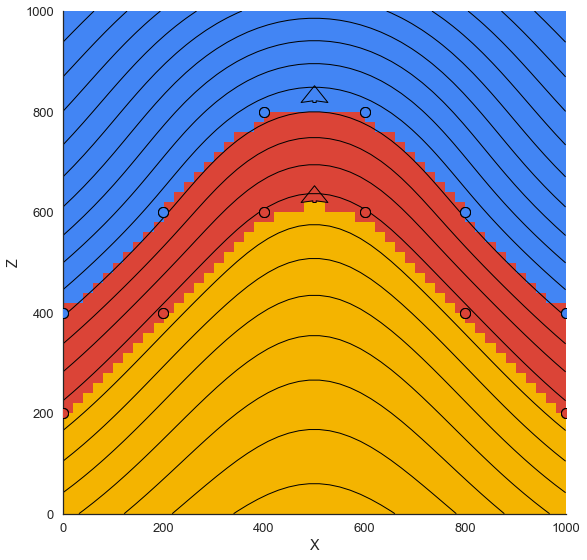

In [21]:
%matplotlib inline

gp.plot.plot_section(geo_data, cell_number=0)
gp.plot.plot_scalar_field(geo_data, cell_number=0, N=20, show_data=False, alpha=0, colors='k', cmap=None, linewidths=1)

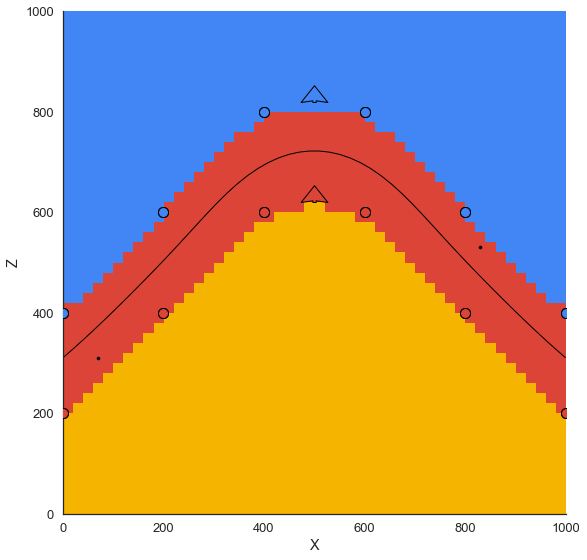

In [22]:
gp.plot.plot_section(geo_data, cell_number=0)
#plt.scatter(sol.grid.regular_grid.values[:,0], sol.grid.regular_grid.values[:,2], s=1, c='black')
plt.scatter(sol.grid.regular_grid.values[165,0], sol.grid.regular_grid.values[165,2], s=10, c='black', marker='o')
plt.scatter(sol.grid.regular_grid.values[2076,0], sol.grid.regular_grid.values[2076,2], s=10, c='black', marker='o')
#plt.plot()
gp.plot.plot_scalar_field(geo_data, cell_number=0, N=1, show_data=False, alpha=0, colors='k', cmap=None, linewidths=1)

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, gx)

ValueError: Unknown projection '3d'

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def fun(x, y):
    return x**2 + y

In [ ]:
x = np.arange(-10,10,2)
y = np.arange(-10,10,2)

X, Y = np.meshgrid(x, y)

zs = np.array(fun(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

In [ ]:
gx,gy = np.gradient(Z,2,2)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, gy)